In [1]:
import os
import tarfile
import matplotlib.pyplot as plt
import pandas as pd
from qiskit import BasicAer
from qiskit.utils import QuantumInstance, algorithm_globals

import numpy as np

from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from fcmeans import FCM
from quantum_clustering import QKMeans, QFCMeans

seed = 42
algorithm_globals.random_seed = seed
quantum_instance = QuantumInstance(BasicAer.get_backend('qasm_simulator'), 
                                    shots=10240,
                                    optimization_level=1,
                                    seed_simulator=seed,
                                    seed_transpiler=seed)
# unzip data
path = os.getcwd()
file = tarfile.open(path + '\\data.tar.xz')
file.extractall(path)
file.close()

# read sample data
mdck = pd.read_csv(
    path + '\\data\\2018-02_20 1459-MDCK-CRR.txt', 
    header = None, sep='\t', index_col=0).transpose()

# PCA then scale data for ML
pca = PCA(70)
pca.fit(mdck)
mdck_pca = pca.transform(mdck)

scaler = RobustScaler()
scaler.fit(mdck_pca)
mdck_scaled = scaler.transform(mdck_pca)

In [2]:
random_color_map = {0: np.array([1, 1, 0]), # yellow
             1: np.array([0, 0, 0.294]), # black
             2: np.array([0.6, 0.196, 0.8]), # purple
             3: np.array([0, 1, 0]), # lime
             4: np.array([0.862, 0.078, 0.235]), # red
             5: np.array([0.921, 0.694, 0.203]), # orange
             6: np.array([0.039, 0.411, 0.145]), # dark green
             7: np.array([0.054, 0.552, 0.588])} # turquoise

def transform_labels_to_colorcode(data: np.array,
                                  dimension: int,
                                  color_map: dict,
                                  membership_scores=np.array([])):

    data_reshaped = data.reshape(-1, 100)
    data_colorcoded = np.ndarray(shape=(data_reshaped.shape[0],
                                        data_reshaped.shape[1],
                                        dimension),
                                 dtype=float)
    for i in range(0, data_reshaped.shape[0]):
        for j in range(0, data_reshaped.shape[1]):
            if dimension == 3:
                data_colorcoded[i][j] = color_map[data_reshaped[i][j]]
            elif dimension == 4:
                data_colorcoded[i][j] = np.append(color_map[
                    data_reshaped[i][j]],
                    membership_scores[i][j]*3)
    return data_colorcoded

def reconstruct_image(data: np.array, save_as: str):
    plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(data)

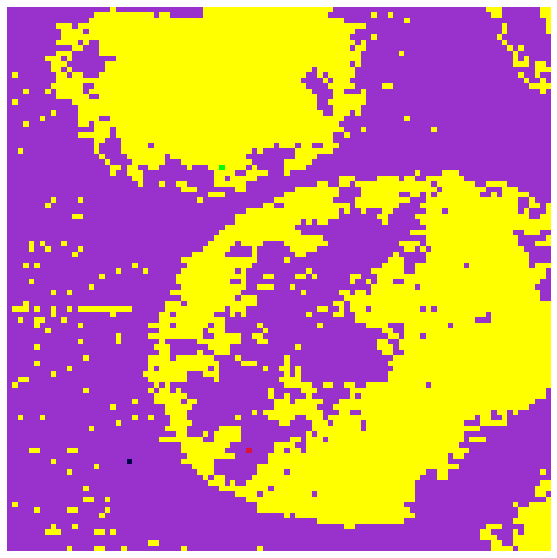

In [3]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(mdck_scaled)
kmeans_centers = kmeans.cluster_centers_
kmeans_labels = kmeans.labels_

kmeans_labels_colorcoded = transform_labels_to_colorcode(
    kmeans_labels, 3, random_color_map)
reconstruct_image(kmeans_labels_colorcoded, 'kmeans')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


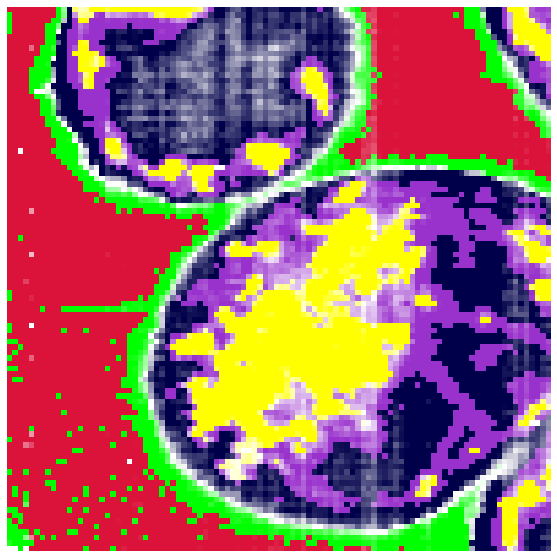

In [4]:
fcm = FCM(n_clusters=5)
fcm.fit(mdck_pca)
fcm_labels = fcm.predict(mdck_pca)
fcm_labels_memberships = fcm.soft_predict(mdck_pca)
fcm_labels_membership = [
    fcm_labels_memberships[i][fcm_labels[i]] for i in range(len(fcm_labels))
    ]

fcm_labels_membership = np.array(fcm_labels_membership)
fcm_labels_membership = fcm_labels_membership.reshape(-1, 100)
membership_scaler = MinMaxScaler()
fcm_labels_membership = membership_scaler.fit_transform(
    fcm_labels_membership
    )

fcm_labels_colorcoded = transform_labels_to_colorcode(
    fcm_labels, 4, random_color_map, membership_scores=fcm_labels_membership)
reconstruct_image(fcm_labels_colorcoded, 'fcm')

In [ ]:
qkmeans = QKMeans(n_clusters=5, quantum_instance=quantum_instance).fit(mdck_scaled[:5])
qkmeans_centers = qkmeans.cluster_centers_
qkmeans_labels = qkmeans.labels_

qkmeans_labels_colorcoded = transform_labels_to_colorcode(
   qkmeans_labels, 3, random_color_map)
reconstruct_image(qkmeans_labels_colorcoded, 'kmeans')

In [ ]:
qfcm = QFCMeans(n_clusters=5, quantum_instance=quantum_instance).fit(mdck_scaled[:5])
qfcm_centers = qkmeans.cluster_centers_
qfcm_labels = qfcm.labels_